# Exercise 1: Gradient Descent

In [1]:
#This cell sets up basic plotting functions awe
#we will use to visualize the gradient descent routines.

#Make plots interactive
#%matplotlib notebook

#Make plots static
%matplotlib inline

#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm
#from itertools import zip_longest

#Import Numpy
import numpy as np

#Define function for plotting 

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-3, 2)
    ax.set_ylim(-3, 2)
    ax.set_zlim( 0, 40)

    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)

    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)

    return ax;

def overlay_trajectory_contour_M(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=14)
    return ax;

def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

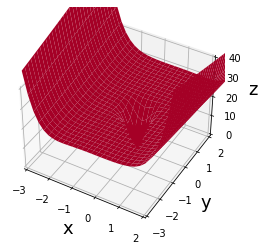

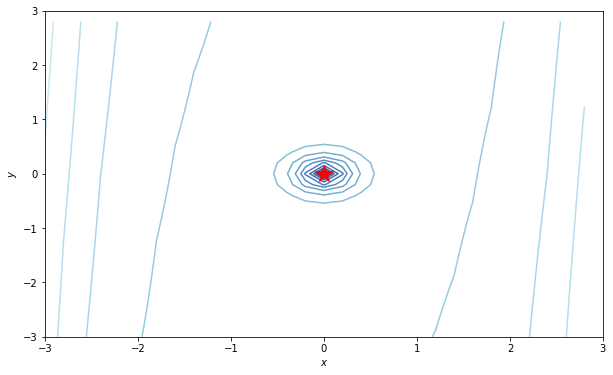

In [2]:
#DEFINE SURFACES WE WILL WORK WITH

# Define the general parameters
w = 10
q = 1 / 10
b = 20

# Define functions and gradient
def f( x, y ):
    return b * ( 1 - np.exp( - w / 2 * ( x**2 + y**2 ) ) ) + q / 2 * ( -x**3 + y )**2

def gradf( params ):
    x      = params[0]
    y      = params[1]
    grad_x = b * np.exp( - w / 2 * ( x**2 + y**2 ) ) * w * x - 3 * q * x**2 * ( -x**3 + y )
    grad_y = b * np.exp( - w / 2 * ( x**2 + y**2 ) ) * w * y -     q        * ( -x**3 + y )
    return [grad_x, grad_y]

def contour_function():
    #plot function
    x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=f(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(0,0, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))

    return fig,ax

#Make plots of surfaces
plt.close() # closes previous plots
x, y = np.mgrid[-3:3:31j, -3:3:31j]
#print(x, y)
fig1,ax1=plot_surface(x,y,f(x,y))

#Contour plot of Function

fig4,ax4 =contour_function()
plt.show()


In [3]:
#This writes a simple gradient descent, gradient descent+ momentum,
#nesterov.

#Mean-gradient based methods
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0):
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj


def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj


def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

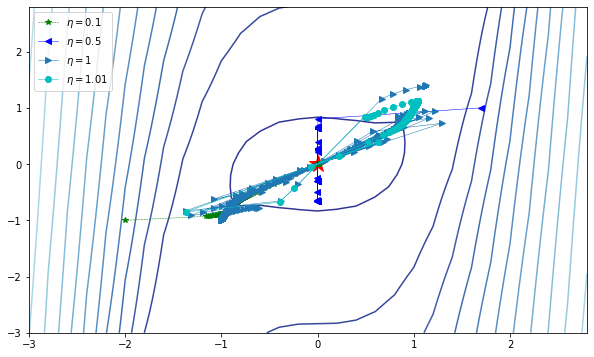

In [4]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(f(x,y))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,-1]
init2=[1.7,1]
init3=[-1,-1]
init4=[1,1]

eta1=0.1
eta2=0.5
eta3=1
eta4=1.01

gd_1=gd(gradf,init1, n_epochs=1000, eta=eta1)
gd_2=gd(gradf,init2, n_epochs=10000, eta=eta2)
gd_3=gd(gradf,init3, n_epochs=1000, eta=eta3)
gd_4=gd(gradf,init4, n_epochs=1000, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)

overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("GD3regimes.pdf", bbox_inches='tight')


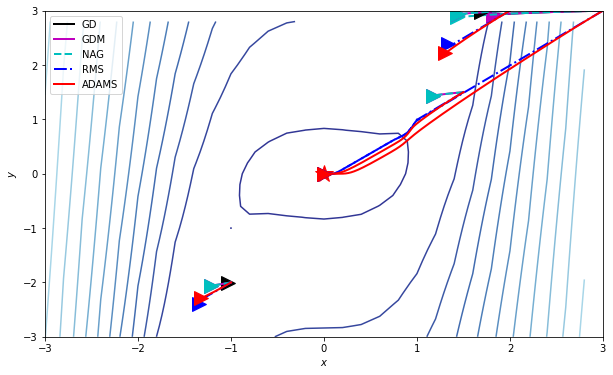

In [9]:
plt.close()
#Make static plot of the results
Nsteps=10**5
lr_l=10**-3
lr_s=10**-6

init1=np.array([3,3])
fig1, ax1=contour_function()

gd_trajectory1=gd(gradf,init1,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory1=gd_with_mom(gradf,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory1=NAG(gradf,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory1=rms_prop(gradf,init1,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory1=adams(gradf,init1,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GD','k')
overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory1, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory1,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory1,'ADAMS', 'r')

plt.legend(loc=2)

init2=np.array([1.5,1.5])
gd_trajectory2=gd(gradf,init2,Nsteps, eta=10**-6, noise_strength=0)
gdm_trajectory2=gd_with_mom(gradf,init2,Nsteps,eta=10**-6, gamma=0.9,noise_strength=0)
NAG_trajectory2=NAG(gradf,init2,Nsteps,eta=10**-6, gamma=0.9,noise_strength=0)
rms_prop_trajectory2=rms_prop(gradf,init2,Nsteps,eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory2=adams(gradf,init2,Nsteps,eta=10**-3, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gdm_trajectory2, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory2, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory2,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory2,'ADAMS', 'r')

init3=np.array([-1,-2])

gd_trajectory3=gd(gradf,init3,10**5, eta=lr_s, noise_strength=0)
gdm_trajectory3=gd_with_mom(gradf,init3,10**5,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory3=NAG(gradf,init3,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory3=rms_prop(gradf,init3,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory3=adams(gradf,init3,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory3, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory3, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory3, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory3,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory3,'ADAMS', 'r')

init4=np.array([2,3])

gd_trajectory4=gd(gradf,init4,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory4=gd_with_mom(gradf,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory4=NAG(gradf,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory4=rms_prop(gradf,init4,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory4=adams(gradf,init4,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory4, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory4, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory4, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory4,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory4,'ADAMS', 'r')

plt.show()

In [10]:
q = 6

def f_2( x, y ):
    return 1 + 0.5 * q * ( x**2 + y**2 ) - np.cos( 2 * np.pi * ( x * y - y**2 ) )

def gradf_2( params ):
    x      = params[0]
    y      = params[1]
    grad_x = q * x + 2 * np.pi           * y   * np.sin( 2 * np.pi * ( x * y - y**2 ) )
    grad_y = q * x + 2 * np.pi * ( x - 2 * y ) * np.sin( 2 * np.pi * ( x * y - y**2 ) )
    return [grad_x, grad_y]

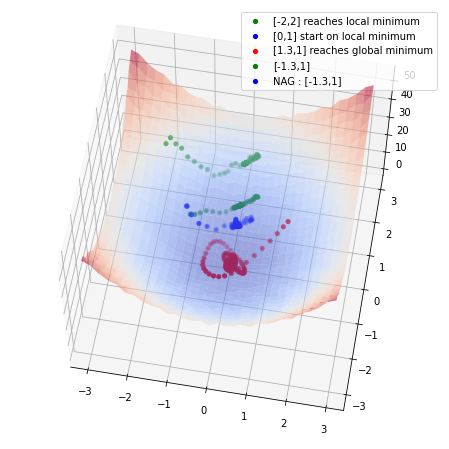

In [14]:
x, y = np.mgrid[-3:3:31j, -3:3:31j]

fig = plt.figure( figsize = ( 8, 8 ) )
ax  = fig.add_subplot(projection = '3d')

ax.plot_surface( x, y, f_2( x, y ), cmap = 'coolwarm', alpha = 0.5)
ax.view_init(60,280)

P1 = adams(gradf_2, [-2,2], n_epochs=250, eta=0.1, noise_strength=0,)
ax.scatter(P1[:,0], P1[:,1], f_2(P1.T[0], P1.T[1]), marker = '.', color = 'green', linewidth = 3, label = "[-2,2] reaches local minimum")

P2 = adams(gradf_2, [0,1], n_epochs=2000, eta=0.1, noise_strength=0,) #local minimum
ax.scatter(P2[:,0], P2[:,1], f_2(P2.T[0], P2.T[1]), marker = '.', color = 'blue', linewidth = 3, label = "[0,1] start on local minimum")

P3 = adams(gradf_2, [1.3,1], n_epochs=20000, eta=0.1, noise_strength=0,)
ax.scatter(P3[:,0], P3[:,1], f_2(P3.T[0], P3.T[1]), marker = '.', color = 'red', linewidth = 3, label = "[1.3,1] reaches global minimum")

#An other point that do not converge in the global minimum
P4 = adams(gradf_2, [-1.3,1], n_epochs=250, eta=0.1, noise_strength=0,)
ax.scatter(P4[:,0], P4[:,1], f_2(P4.T[0], P4.T[1]), marker = '.', color = 'green', linewidth = 3, label = "[-1.3,1]")

#NAG instead converge
P_NAG = NAG(gradf_2, [-1.3,1], n_epochs=250, eta=0.01, noise_strength=0,)
ax.scatter(P_NAG[:,0], P_NAG[:,1], f_2(P_NAG.T[0], P_NAG.T[1]), marker = '.', color = 'blue', linewidth = 3, label = "NAG : [-1.3,1]")

ax.legend()
plt.show()